# Visualizing intermediate activations

In [1]:
from keras.models import load_model
from keras import models

from keras.preprocessing import image
import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Parameters

In [2]:
base_dir = './cats_and_dogs_small/'

In [3]:
file_model = base_dir+'/cats_and_dogs_small_1.h5'

In [4]:
img_path = base_dir + '/test/cats/cat.1792.jpg'

### Read model from file

In [5]:
model = load_model(file_model)

### Model info

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Read and preprocess image

In [7]:
img = image.load_img(img_path, target_size=(150, 150))

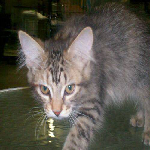

In [8]:
img

In [9]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

### Note: numbers in the range 0-255

In [10]:
img_tensor[0][0][2]

array([8., 9., 3.], dtype=float32)

In [11]:
img_tensor /= 255.

In [12]:
print(img_tensor.shape)

(1, 150, 150, 3)


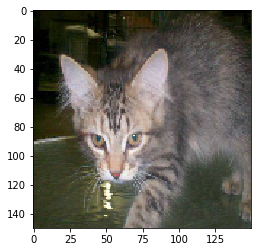

In [13]:
plt.imshow(img_tensor[0])
plt.show()

# Read layers

In [14]:
model.layers

In [15]:
model.layers[0].output

<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 148, 148, 32) dtype=float32>

### Extracts the outputs of the top eight layers

In [16]:
layer_outputs = [layer.output for layer in model.layers[:8]]

### New model that will return the outputs of the layers, given the model input

#### (This is a multi-output model)

In [17]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

### Prediction on the activation (the output of a layer)

In [18]:
activations = activation_model.predict(img_tensor)

### First activation

In [19]:
first_layer_activation = activations[0]

In [20]:
print(first_layer_activation.shape) #It’s a 148 × 148 feature map with 32 channels: (1, size, size, n_features).

(1, 148, 148, 32)


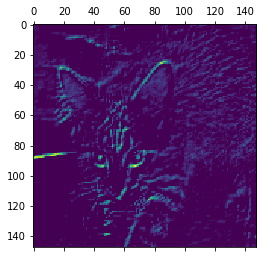

In [21]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

# Plot all

In [22]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

In [23]:
layer_names

['conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'max_pooling2d_4']

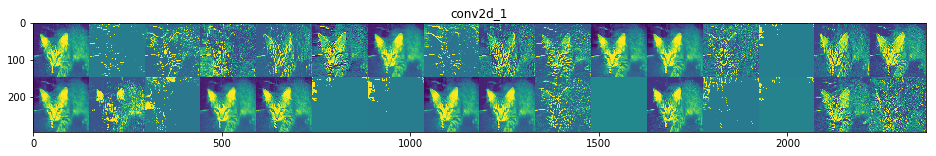

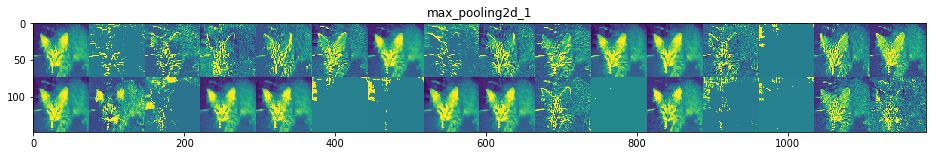

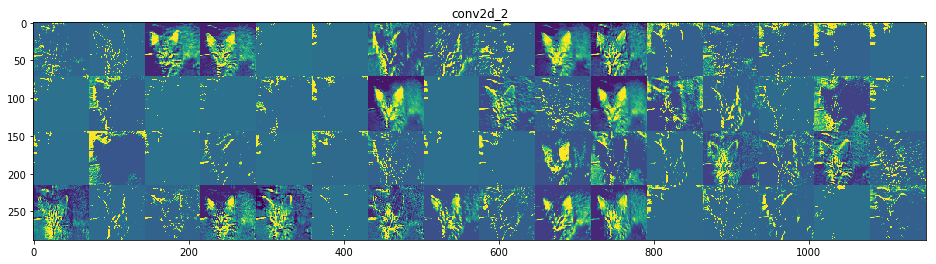

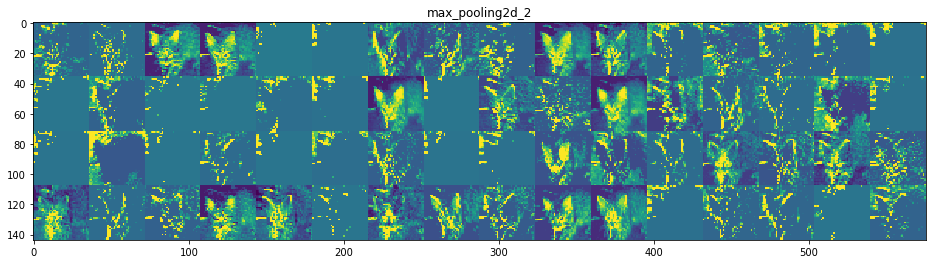

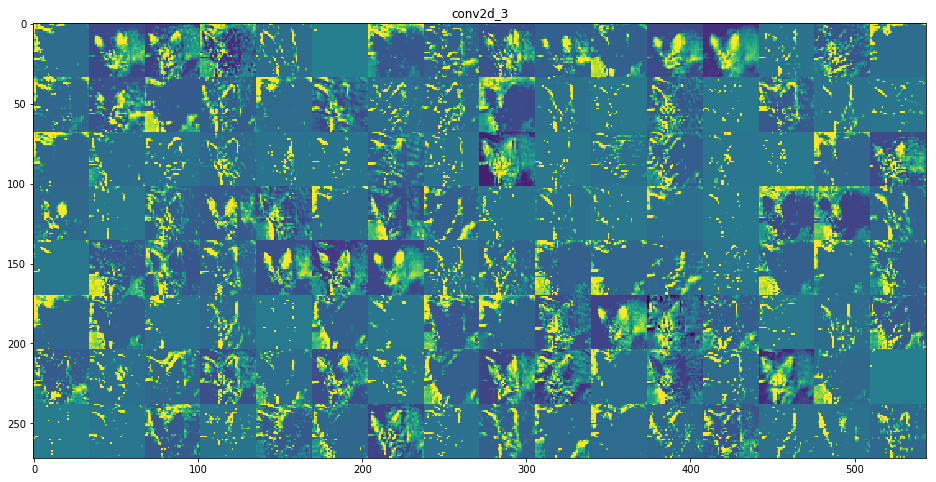

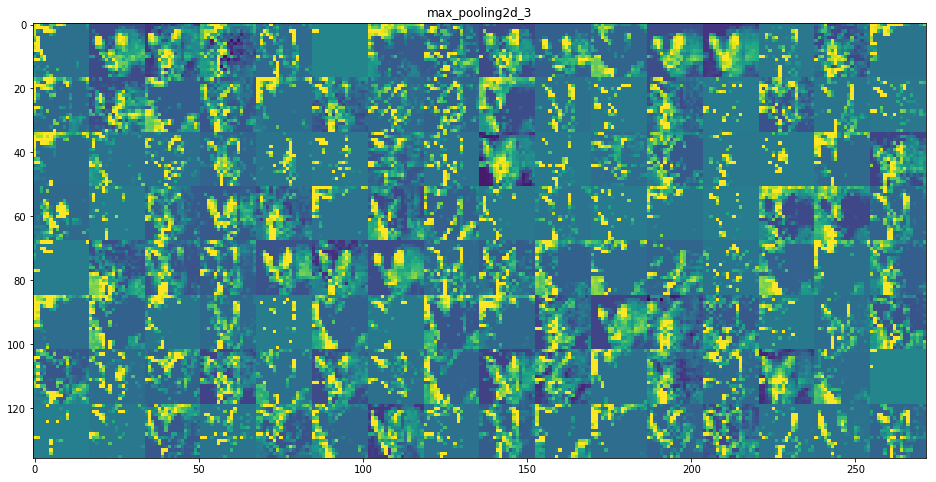

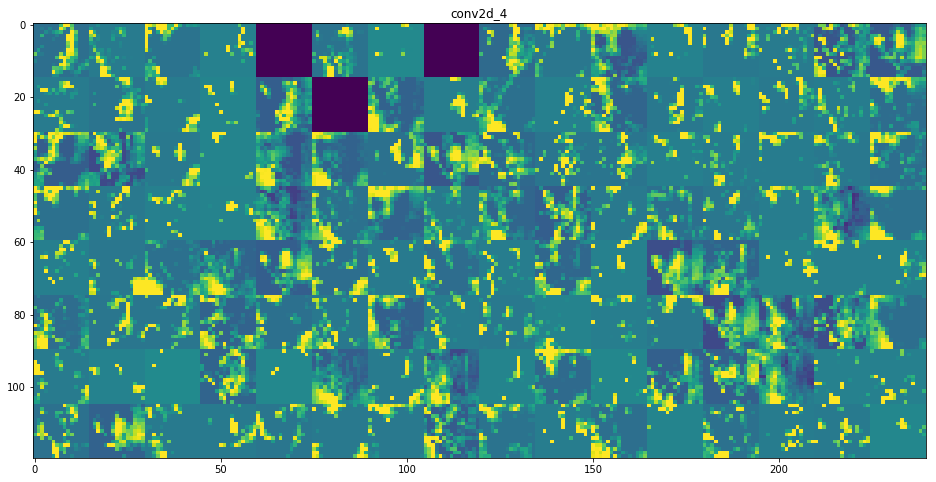

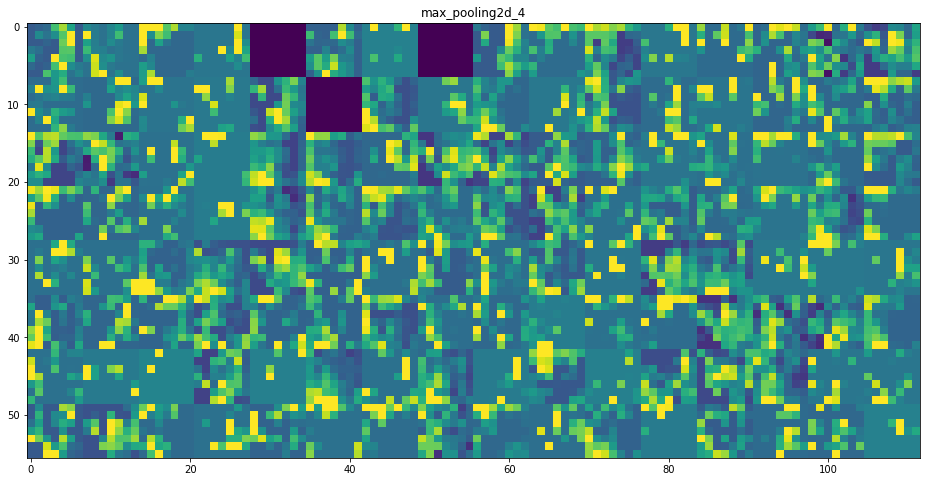

In [25]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, col * images_per_row + row]
            
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            
            #smaller than 0 ->0, bigger than 255 -> 255
            #then, transform to integer
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') 

            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')    